# Stock Price Analysis

by [Armin Oliya](https://nl.linkedin.com/in/oliya), Dec 2016

In this notebook we'll analyze and experiment with time-series data; specifically, stock data downloaded from Yahoo finance. We'll start by doing some basic analysis such as finding the trend and move on to measure volatility and comparing development of multiple stocks. At the end, we'll be doing price prediction based on historical data using Support Vector Regression (SVR) and Deep Learning.


Populating the interactive namespace from numpy and matplotlib


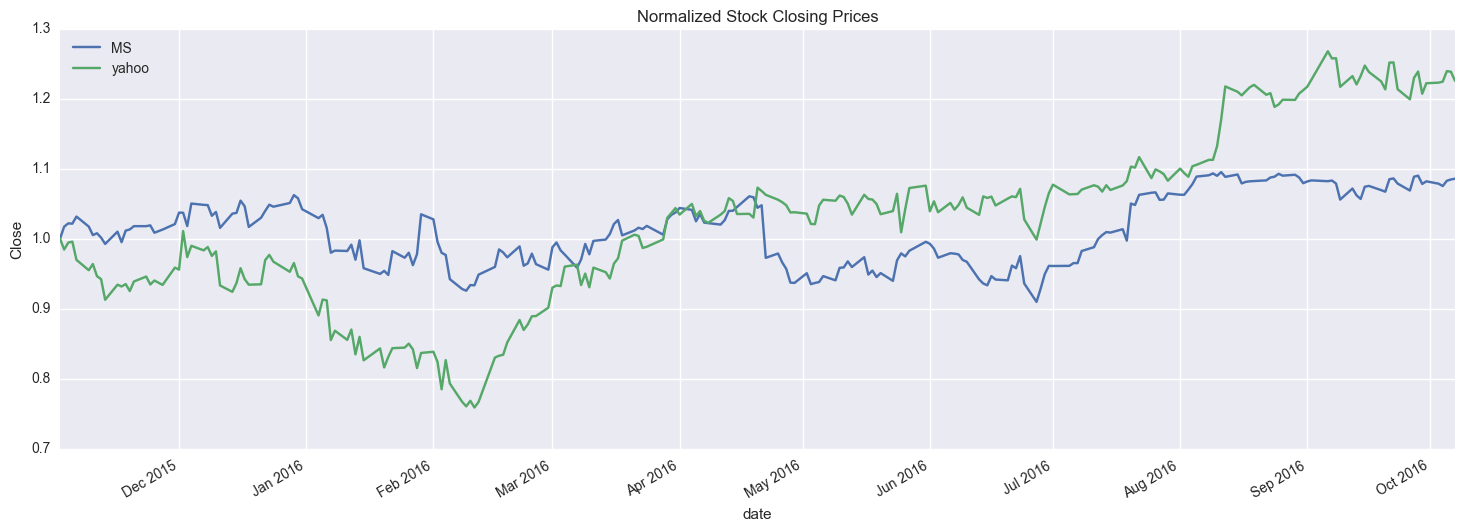

In [19]:
# Parsing and showing multiple stocks
# data downloaded from yahoo finance e.g. https://finance.yahoo.com/quote/YHOO/history?p=YHOO


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import datetime
%pylab inline

start_date = '2015-11-01'
end_date = '2016-11-01'

dates = pd.date_range(start_date,end_date)
datesDF = pd.DataFrame(index=dates)
# datesDF.head()

symbols = ['MS','yahoo']
df = datesDF




for s in symbols:
    tempDF = pd.read_csv("data/{}.csv".format(s),encoding="utf-8",index_col='Date',parse_dates = True,usecols=['Date','Close'])    
    tempDF = tempDF.rename(columns={'Close': s})

    df = df.join(tempDF)
# , 
df=df.dropna()
normalizedDF = df/df.ix[0,:] # normalizing values across different stocs 
ax = normalizedDF.plot(title="Normalized Stock Closing Prices", figsize=(18,6))
# ax.width('500px')
ax.set_xlabel('date')
ax.set_ylabel('Close')

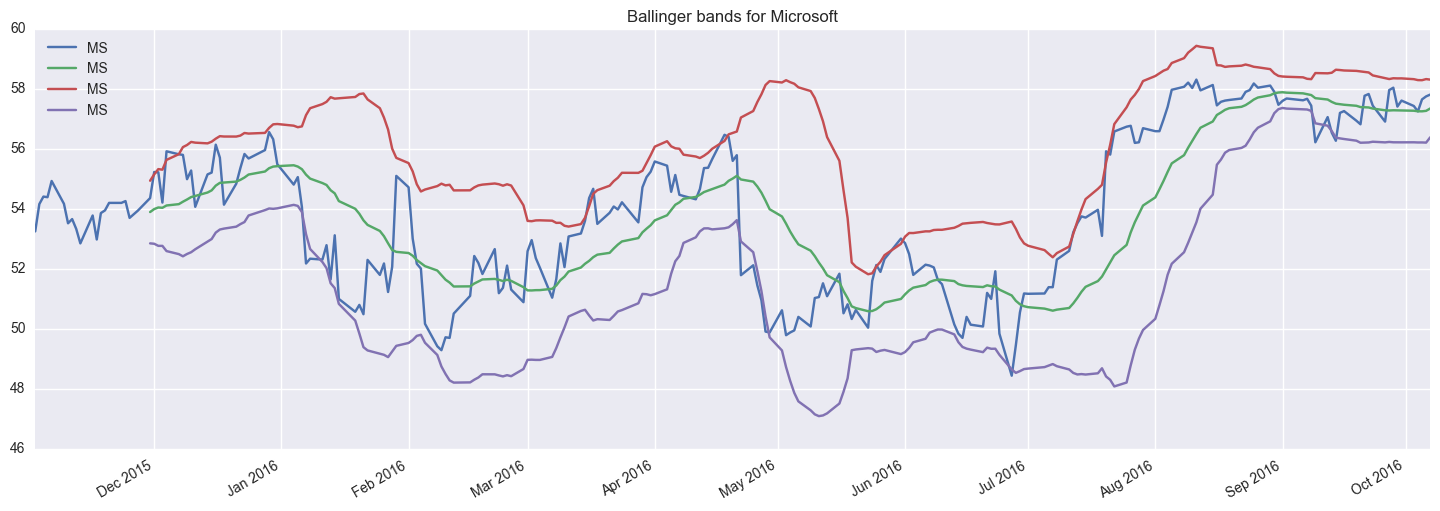

In [2]:
# Rolling mean, std & Ballinger bands

msDF = df[['MS']]
rolling_mean = msDF.rolling(window = 20, center=False).mean()
rolling_std = msDF.rolling(window = 20, center=False).std()
upper_band = rolling_mean+2*rolling_std
lower_band = rolling_mean-2*rolling_std

#DataFrame.rolling(window=20,center=False).mean()
plt1 = msDF.plot(title='Ballinger bands for Microsoft',legend='MS', figsize=(18,6))
rolling_mean.plot(legend='mean', ax=plt1)
upper_band.plot(legend='upper',ax=plt1)
lower_band.plot(legend='lower',ax=plt1)
# labels don't work, alternative: plt1.legend(['Popularity', 'RateMedian', 'FirstPpl', 'FirstRM'])

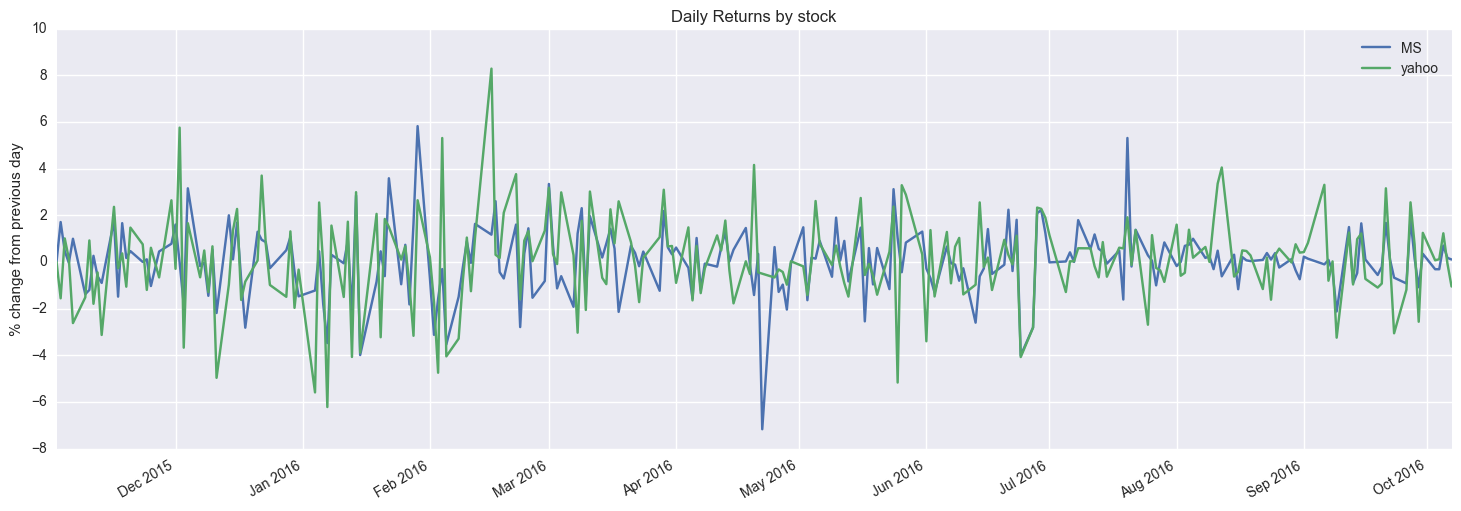

In [3]:
#Daily returns

dailyReturns = 100*(df/df.shift(1) - 1)
dailyReturns.ix[0,]=0.0

dplt = dailyReturns.plot(title="Daily Returns by stock", figsize=(18,6))
dplt.set_ylabel('% change from previous day')



Kurtosis:
MS       3.792397
yahoo    1.865550
dtype: float64


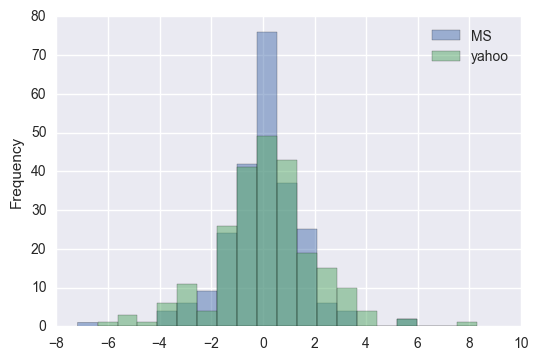

In [4]:
#histogram for daily returns 
# dailyReturns[['MS']].hist(bins=20)
# dailyReturns[['yahoo']].hist(bins=20)

ms_mean = dailyReturns[['MS']].mean()
ms_std = dailyReturns[['MS']].std()

print "Kurtosis:\n",dailyReturns.kurtosis()

plt.figure()
dailyReturns.plot(kind='hist', alpha=0.5,bins=20)
## can't get this shit working :(
# plt.axvline(ms_mean, color='b', linestyle='dashed', linewidth=2)
# plt.axvline(ms_std, color='b', linestyle='dashed', linewidth=2)
# plt.axvline(-ms_std, color='b', linestyle='dashed', linewidth=2)



This shows that MS stock is slightly more volatile.

In probability theory and statistics, **kurtosis** (from Greek meaning "curved, arching") is a measure of the "tailedness" of the probability distribution of a real-valued random variable. In a similar way to the concept of skewness, kurtosis is a descriptor of the shape of a probability distribution. 

The kurtosis of any univariate normal distribution is 3. It is common to compare the kurtosis of a distribution to this value. Distributions with kurtosis less than 3 are said to be platykurtic, although this does not imply the distribution is "flat-topped" as sometimes reported. Rather, it means the distribution produces fewer and less extreme outliers than does the normal distribution. An example of a platykurtic distribution is the uniform distribution, which does not produce outliers. Distributions with kurtosis greater than 3 are said to be leptokurtic. An example of a leptokurtic distribution is the Laplace distribution, which has tails that asymptotically approach zero more slowly than a Gaussian, and therefore produces more outliers than the normal distribution. It is also common practice to use an adjusted version of Pearson's kurtosis, the excess kurtosis, which is the kurtosis minus 3, to provide the comparison to the normal distribution. Some authors use "kurtosis" by itself to refer to the excess kurtosis. For the reason of clarity and generality, however, this article follows the non-excess convention and explicitly indicates where excess kurtosis is meant.

So in our case, Microsoft is more likely to incur surprisingly higher returns/losses. 


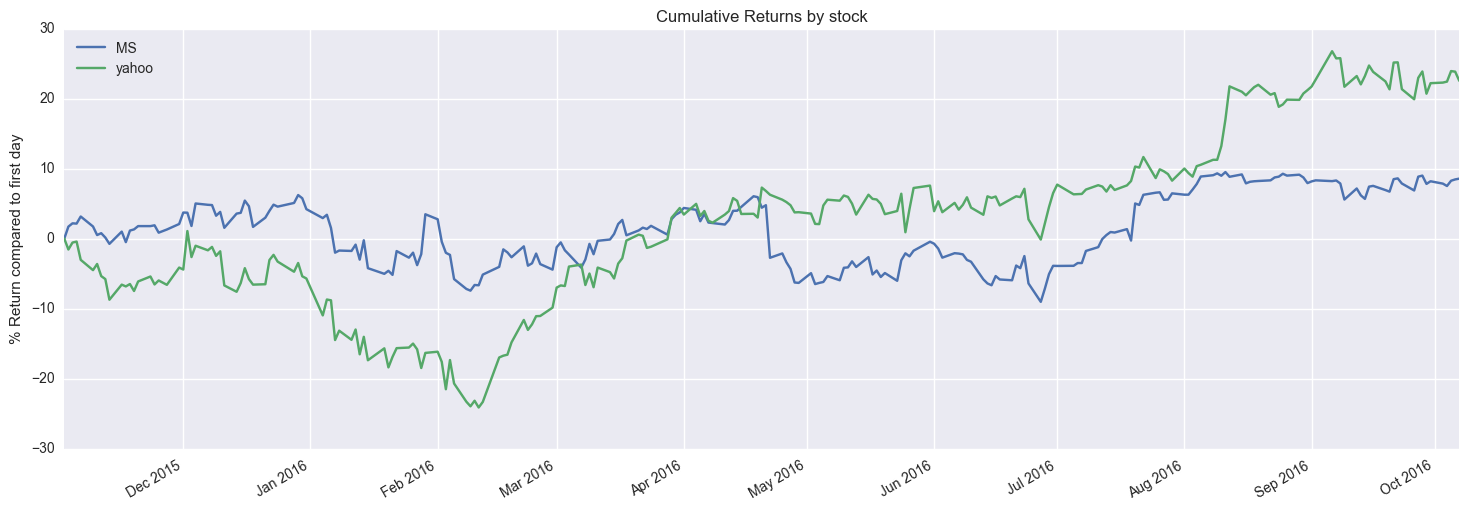

In [5]:
#Cumulative Returns 
cumulativeReturns = 100*(df/df.ix[0] - 1)


cplt = cumulativeReturns.plot(title="Cumulative Returns by stock", figsize=(18,6))
cplt.set_ylabel('% Return compared to first day')

This is the returns you could expect compared to the first data point, that is, if you had invested in yahoo in Nov 2015, you would get a +20% return on your investment. 


beta: 0.596932094366, alpha: 0.077859459062
correlation between returns: 
             MS     yahoo
MS     1.000000  0.446737
yahoo  0.446737  1.000000


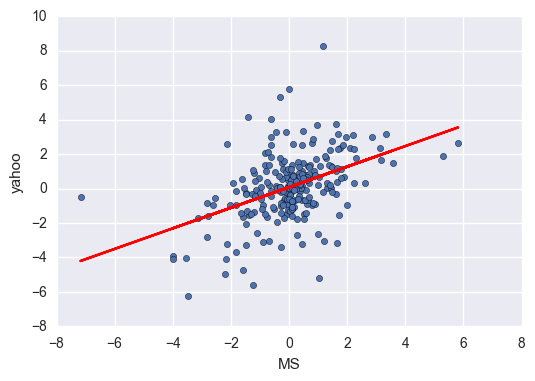

In [6]:
## How are returns between MS and yahoo stocks related?
import numpy as np 

dailyReturns.plot(kind='scatter', x="MS", y="yahoo" )

beta, alpha = np.polyfit(dailyReturns['MS'],dailyReturns['yahoo'],1)
plt.plot(dailyReturns['MS'],dailyReturns['MS']*beta+alpha,'-',color='r')

print "beta: {0}, alpha: {1}".format(beta,alpha)
print "correlation between returns: \n", dailyReturns.corr(method="pearson")

For every step increase in daily retuns of microsoft, beta tells us that yahoo's return will increase by almost half (beta). The alpha value (0.078) tells us that yahoo's stock is performing on average slightly better every day. 

And we can see that there's a noticeable correlation between returns (0.44).


## Prediction

Let's try predicting the stock price. To create training and test sets, I'm going to split the data along the time axis; that is, i use stock prices for the first 8 months for training and the remaining months for testing. 

In [127]:
# fix random seed for reproducibility
numpy.random.seed(7)

MS_training_df = pd.read_csv("data/{}.csv".format(s),encoding="utf-8",usecols=['Close'])    

train_size = int(len(MS_training_df) * 0.67)
test_size = len(MS_training_df) - train_size
train, test = MS_training_df.iloc[0:train_size], MS_training_df.iloc[train_size:len(MS_training_df)]

print("train and test size: ",len(train), len(test))

('train and test size: ', 168, 84)


In [136]:
from sklearn.svm import SVR


# svr_linear = SVR(kernel='linear')
svr_poly = SVR(kernel='poly',  degree=4,C=1e2,gamma=0.005)
svr_rbf = SVR(kernel='rbf', C=1e2,gamma=0.005)

trainX = train.index.values.reshape(-1,1)
trainY = train.values.reshape(-1,1)

# svr_linear.fit(trainX,trainY)
svr_poly.fit(trainX,trainY)
svr_rbf.fit(trainX,trainY)



SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.005,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Changing C and gamma has dramatic effect on the performance of SVR with completely different results.
- high gamma: points close to the decision boundry have higher importance (extreme values would over fit) 
- C: trade off between Smooth decision boundry and classifying all points correctly. High C favors as few misclassifications as possible, while low c favors a generic model

I managed to get better results by choosing a low gamma and C=100; by better results i mean lines that don't over-fit and seem to follow the general pattern in the data. 


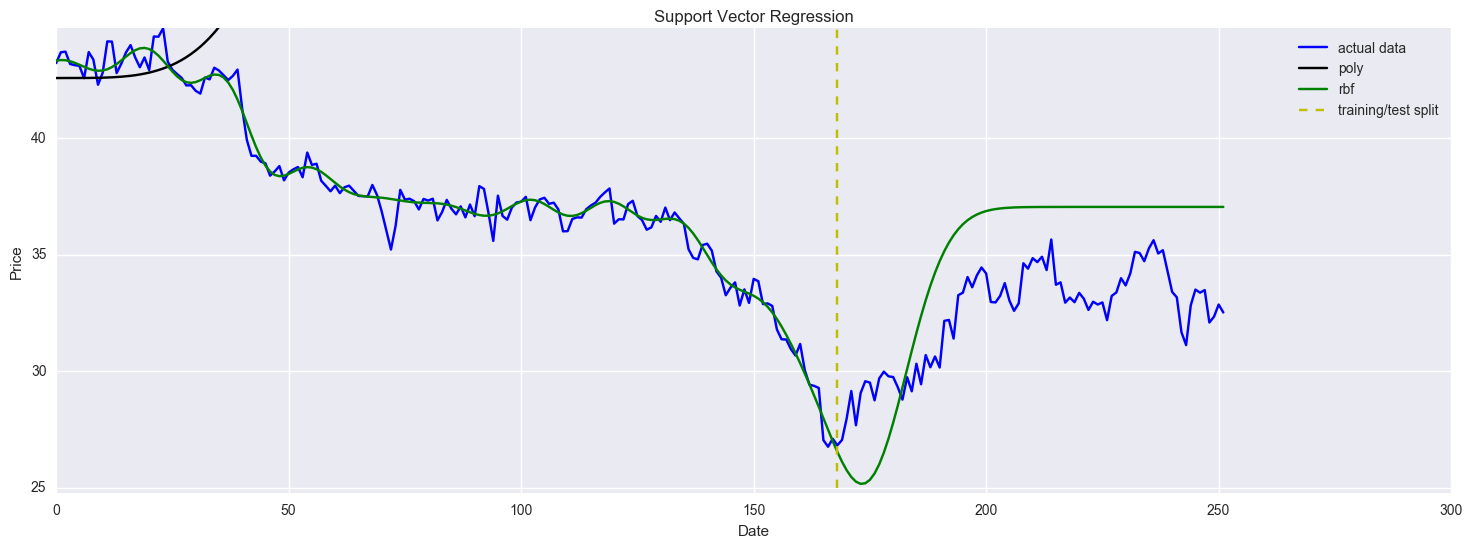

In [140]:

alldataX = MS_training_df.index.values.reshape(-1,1)
alldataY = MS_training_df.values.reshape(-1,1)


plt.figure(figsize=(18,6))

plt.plot(MS_training_df,color='blue',label='actual data')
# plt.plot(trainX,svr_linear.predict(trainX),color='blue',label='linear')
plt.plot(alldataX,svr_poly.predict(alldataX),color='black',label='poly')
plt.plot(alldataX,svr_rbf.predict(alldataX),color='green',label='rbf')
plt.plot((train_size, train_size), (25, 45), 'y',label="training/test split",linestyle='--')

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Support Vector Regression")

axes = plt.gca()
axes.set_ylim([min(alldataY)-2,max(alldataY)])

plt.legend()
plt.show()

The polynomial model is way off (even after trying various degrees). The nice thing about RBF kernel is that it's highly malleable: you could adjust C and gamma so that it's highly overfitting or you could make it more generic. The current values seem to be working 'ok' in capturing the general price development trend but predictions are not that reliable. Most notably it starts leveling off after day 200; this could be because of the not so high fluctuations in that period though.

So far, we've been using the dates as input features. Another way, is to look back into the stock prices in past few days as features (look-back window) and use the value for tomorrow as target. So the input space will change from dates to historical values. 

In [141]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataset.reshape(-1,1)
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)



In [142]:
# This look_back variable is our window size, how far in past data do we want to look at?
look_back = 5

trainX, trainY = create_dataset(train.values, look_back)
testX, testY = create_dataset(test.values, look_back)

In [143]:
# checking our dataset
for i in range(10):
    print (trainX[i],trainY[i])

(array([ 43.220001,  43.68    ,  43.709999,  43.18    ,  43.130001]), 43.099997999999999)
(array([ 43.68    ,  43.709999,  43.18    ,  43.130001,  43.099998]), 42.57)
(array([ 43.709999,  43.18    ,  43.130001,  43.099998,  42.57    ]), 43.689999)
(array([ 43.18    ,  43.130001,  43.099998,  42.57    ,  43.689999]), 43.369999)
(array([ 43.130001,  43.099998,  42.57    ,  43.689999,  43.369999]), 42.290001000000004)
(array([ 43.099998,  42.57    ,  43.689999,  43.369999,  42.290001]), 42.799999)
(array([ 42.57    ,  43.689999,  43.369999,  42.290001,  42.799999]), 44.150002000000001)
(array([ 43.689999,  43.369999,  42.290001,  42.799999,  44.150002]), 44.139998999999996)
(array([ 43.369999,  42.290001,  42.799999,  44.150002,  44.139999]), 42.790001000000004)
(array([ 42.290001,  42.799999,  44.150002,  44.139999,  42.790001]), 43.189999)


In [121]:
# now we'll retrain our SVR models using this new dataset

svr_rbf_with_look_back = SVR(kernel='rbf', C=100,gamma=0.005)
svr_rbf_with_look_back.fit(trainX,trainY)


SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.005,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [144]:
#predict values based on our model and save them for visualization
svr_dataframe = MS_training_df.copy()


for i in range(look_back,len(svr_dataframe)):
    svr_dataframe.loc[i] = svr_rbf_with_look_back.predict(svr_dataframe.iloc[i-look_back:i].values.reshape(1,-1))

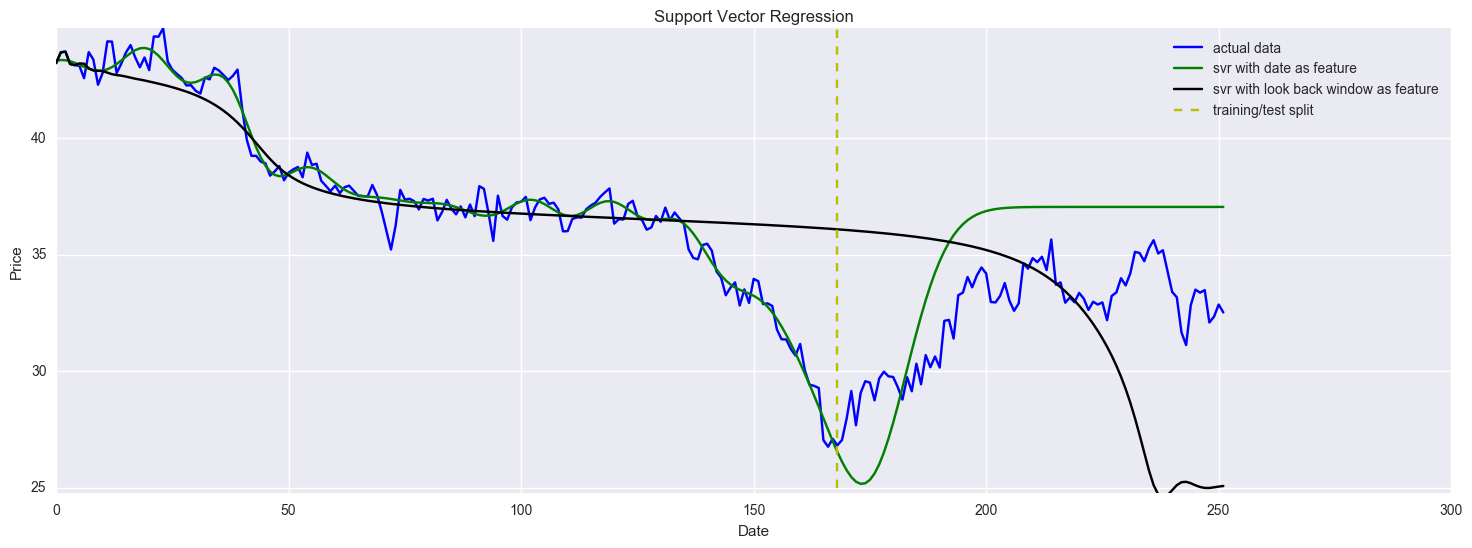

In [162]:
#just to make sure we have clean data for the 'old' svr prediction
alldataX = MS_training_df.index.values.reshape(-1,1)


plt.figure(figsize=(18,6))

plt.plot(MS_training_df,color='blue',label='actual data')
plt.plot(alldataX,svr_rbf.predict(alldataX),color='green',label='svr with date as feature')
plt.plot(svr_dataframe,color='black',label='svr with look back window as feature')

plt.plot((train_size, train_size), (25, 45), 'y',label="training/test split",linestyle='--')


axes = plt.gca()
axes.set_ylim([min(alldataY)-2,max(alldataY)])



plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Support Vector Regression")
plt.legend()
plt.show()

The look-back approach seems to be less sensetive to data fluctuations and more generic, but it's not performing better when it comes to test data. #TODO: calculate mean square for a more accurate comparison

## Deep Learning

I wonder if using a deep neural net could have an advantage here, let's figure it out.

In [174]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()

model.add(Dense(32,input_dim = look_back, init='normal',activation='relu'))
model.add(Dense(32, init='normal',activation='relu'))
model.add(Dense(32, init='normal',activation='relu'))
model.add(Dense(32, init='normal',activation='relu'))
model.add(Dense(32, init='normal',activation='relu'))
model.add(Dense(32, init='normal',activation='relu'))
model.add(Dense(32, init='normal',activation='relu'))

model.add(Dense(output_dim=1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [175]:
numpy.random.seed(7)


# re-getting data to make sure we're working on clean variables
MS_training_df = pd.read_csv("data/{}.csv".format(s),encoding="utf-8",usecols=['Close'])    

train_size = int(len(MS_training_df) * 0.67)
test_size = len(MS_training_df) - train_size
train, test = MS_training_df.iloc[0:train_size], MS_training_df.iloc[train_size:len(MS_training_df)]


look_back = 5
trainX, trainY = create_dataset(train.values, look_back)
testX, testY = create_dataset(test.values, look_back)

In [176]:
for i in range(10):
    print (trainX[i],trainY[i])

(array([ 43.220001,  43.68    ,  43.709999,  43.18    ,  43.130001]), 43.099997999999999)
(array([ 43.68    ,  43.709999,  43.18    ,  43.130001,  43.099998]), 42.57)
(array([ 43.709999,  43.18    ,  43.130001,  43.099998,  42.57    ]), 43.689999)
(array([ 43.18    ,  43.130001,  43.099998,  42.57    ,  43.689999]), 43.369999)
(array([ 43.130001,  43.099998,  42.57    ,  43.689999,  43.369999]), 42.290001000000004)
(array([ 43.099998,  42.57    ,  43.689999,  43.369999,  42.290001]), 42.799999)
(array([ 42.57    ,  43.689999,  43.369999,  42.290001,  42.799999]), 44.150002000000001)
(array([ 43.689999,  43.369999,  42.290001,  42.799999,  44.150002]), 44.139998999999996)
(array([ 43.369999,  42.290001,  42.799999,  44.150002,  44.139999]), 42.790001000000004)
(array([ 42.290001,  42.799999,  44.150002,  44.139999,  42.790001]), 43.189999)


In [177]:
model.fit(trainX, trainY, nb_epoch=500, batch_size=64)


Epoch 1/500
162/162 [==============================] - 0s - loss: 1431.3596     
Epoch 2/500
162/162 [==============================] - 0s - loss: 1430.5934     
Epoch 3/500
162/162 [==============================] - 0s - loss: 1429.6924     
Epoch 4/500
162/162 [==============================] - 0s - loss: 1428.6388     
Epoch 5/500
162/162 [==============================] - 0s - loss: 1427.3470     
Epoch 6/500
162/162 [==============================] - 0s - loss: 1425.6637     
Epoch 7/500
162/162 [==============================] - 0s - loss: 1423.3352     
Epoch 8/500
162/162 [==============================] - 0s - loss: 1419.8972     
Epoch 9/500
162/162 [==============================] - 0s - loss: 1414.4501     
Epoch 10/500
162/162 [==============================] - 0s - loss: 1405.7608     
Epoch 11/500
162/162 [==============================] - 0s - loss: 1391.4513     
Epoch 12/500
162/162 [==============================] - 0s - loss: 1367.9828     
Epoch 13/500
162/162 [===

In [178]:
#quick test
model.predict(np.random.uniform(low=35, high=45, size=(1,look_back)))

array([[ 38.84141922]], dtype=float32)

In [179]:
#predict values based on our model and save them for visualization
nn_dataframe = MS_training_df.copy()


for i in range(look_back,len(nn_dataframe)):
    nn_dataframe.loc[i] = model.predict(nn_dataframe.iloc[i-look_back:i].values.reshape(1,-1))

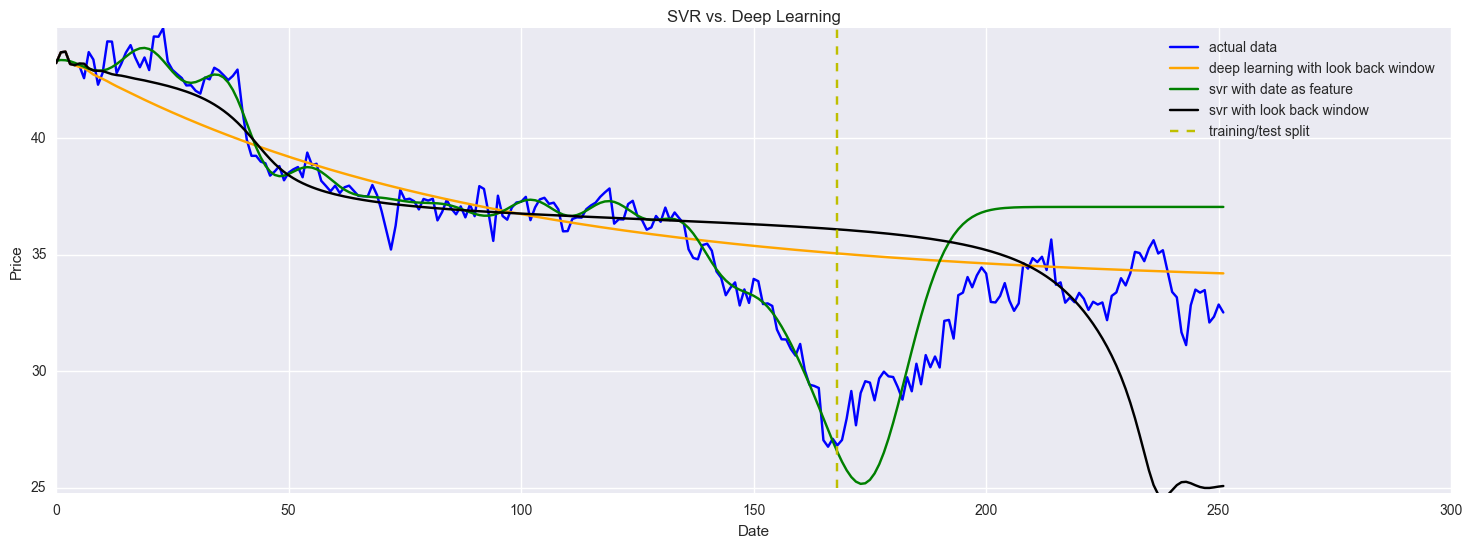

In [182]:
plt.figure(figsize=(18,6))


plt.plot(MS_training_df,color='blue',label='actual data')

plt.plot(nn_dataframe,color='orange',label='deep learning with look back window ')


plt.plot(alldataX,svr_rbf.predict(alldataX),color='green',label='svr with date as feature')
plt.plot(svr_dataframe,color='black',label='svr with look back window')

plt.plot((train_size, train_size), (25, 45), 'y',label="training/test split",linestyle='--')


# aesthetics 
axes = plt.gca()
axes.set_ylim([min(alldataY)-2,max(alldataY)])

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("SVR vs. Deep Learning")
plt.legend()
plt.show()

Compared to SVR, this seems to be an even more generic and totally ignoring price fluctuations. I guess applicability of this curves depends on how long in the future we want to predict. A more generic model could be more suitable to forecase long-term trends while a more biased model could be more appropritate for hourly/daily forecasts. 

Something important to note here is that all these models rely on historical data, specifically data from a few days back. So their best bet is to have seen a similar pattern of development in the past to be able to make an accurate prediction, ignoring all other factors. So the window size that we choose is quite important and should be actually decided by looking at the specific stocks we're analyzing and identifying the magnitude of repeatable patterns, if any.

With regards to our prediction approach, we could improve it by including data from previous years + doing cross validation with different splits of training/test across the time. 

#todo: reinforcement learning